In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
import keras as ks
from keras.preprocessing import image as kimage
import skimage.io as io
import random
import sys
import pickle as pkl
from imblearn.keras import BalancedBatchGenerator
from keras.utils import np_utils
lib_path = os.path.join(os.path.realpath(r"C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\DataAugmentationForObjectDetection-master"), "data_aug")
sys.path.append(lib_path)
from bbox_util import *
from data_aug import *
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.models import Model
from keras.layers import Concatenate,Input, Dense, Flatten, Reshape, MaxPooling2D, Conv2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.layers import Activation, Dense, Dropout, BatchNormalization, LeakyReLU
from keras.optimizers import SGD
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, explained_variance_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.utils import shuffle
import skimage as sk
from skimage import transform
from skimage import util
from keras import backend as K

In [3]:
from sigopt import Connection
conn = Connection(client_token="JQVTZXATLGBWVPBSFXFMTQJDQQGFJGNLBJKZNWOTTRVFGEMB")

## Import dei dati

In [5]:
X = np.load(r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\X.npy')
Y = np.load(r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\Y.npy')
X_test = np.load(r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\X_test.npy')
y_test = np.load(r'C:\Users\Giobi\OneDrive - Universita degli Studi di Milano-Bicocca\Digital Signal and Image Management\Progetto Segnali Stradali\y_test.npy')

## Preprocessing

In [6]:
opt = ks.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.99)
opt2 = SGD(lr=0.001, momentum=0.9, nesterov=True, decay=0.001) # lr = 0.01, decay=0.0001
opt3 = ks.optimizers.RMSprop(lr=0.001, rho=0.9)
opt4 = ks.optimizers.Adagrad(lr=0.01)
opt5 = ks.optimizers.Adadelta(lr= 1.0, rho=0.95)
opt6 = ks.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False)
opt7 = ks.optimizers.Adamax(lr=0.002, beta_1=0.9, beta_2=0.999)

L'array y_train ha i seguenti valori:
- è un segnale? si = 1, no = 0 (binaria)
- 0...43 classi
- rx1
- rx2
- ry1
- ry2

In [7]:
Y = Y[:, 1:] #visto che sono tutti segnali, elimino la prima colonna (quella che dice se c'è o meno il segnale)    
y_test = y_test[:, 1:]

In [8]:
#X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, stratify = Y[:, 0:43], shuffle = True) #ho controllato che la stratificazione è giusta
#X_train = X_train/255
#X_test = X_test/255
#X_val = X_val/255

In [9]:
y_train = Y.copy()
X_train = X.copy()
X_train = X_train/255
X_test = X_test/255
X_train, y_train = shuffle(X_train, y_train)

In [8]:
def random_noise(image_array):
    # add random noise to the image
    return sk.util.random_noise(image_array, var = 0.001)
def augmentation(immagini, y):
    inter = [cv2.INTER_NEAREST, cv2.INTER_LINEAR, cv2.INTER_LANCZOS4]
    for i in range(0, immagini.shape[0]):
        down = cv2.resize(immagini[i], (30,30), interpolation = random.choice(inter))
        immagini[i] = cv2.resize(down, (40,40))
        immagini[i] = random_noise(immagini[i])
    return immagini, y

In [9]:
X_train, y_train = augmentation(X_train, y_train)

# Funzioni Utili

In [10]:
def new_draw_rect(img, bboxes):
    x1 = bboxes[0]
    y1 = bboxes[1]
    x2 = bboxes[2]
    y2 = bboxes[3]
    new_bb = np.array([[x1, y1, x2, y2, 0]])
    plt.imshow(draw_rect(img, new_bb))

In [11]:
def find_area(arr):
    width = arr[2] - arr[0]
    height = arr[1] - arr[3]
    area = width * height
    return area

In [12]:
def run(bboxes1, bboxes2):
    #https://github.com/venuktan/Intersection-Over-Union/blob/master/iou_benchmark.py
    x11, y11, x12, y12 = tf.split(bboxes1, 4, axis=1)
    x21, y21, x22, y22 = tf.split(bboxes2, 4, axis=1)
    xA = tf.maximum(x11, tf.transpose(x21))
    yA = tf.maximum(y11, tf.transpose(y21))
    xB = tf.minimum(x12, tf.transpose(x22))
    yB = tf.minimum(y12, tf.transpose(y22))
    interArea = tf.maximum((xB - xA + 1), 0) * tf.maximum((yB - yA + 1), 0)
    boxAArea = (x12 - x11 + 1) * (y12 - y11 + 1)
    boxBArea = (x22 - x21 + 1) * (y22 - y21 + 1)
    iou = interArea / ((boxAArea + tf.transpose(boxBArea) - interArea)+1)
    return iou

In [13]:
def get_iou(bb1, bb2):
    """
    #https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters
    ----------
    bb1 : dict
        np.array (['x1', 'x2', 'y1', 'y2'])
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : dict
        np.array (['x1', 'x2', 'y1', 'y2'])
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[2]
    assert bb1[1] < bb1[3]
    assert bb2[0] < bb2[2]
    assert bb2[1] < bb2[3]
        # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0
    
    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [16]:
def iou_loss(y_true, y_pred):
    iou = run(y_true, y_pred)
    return 1/(iou + 1) #compreso tra 1/2 e 1

In [17]:
def custom_balance(immagini, segnale, bbox):
    rus = RandomUnderSampler(return_indices=True)
    X_resampled, y_resampled, indexes = rus.fit_sample(immagini.reshape(immagini.shape[0], immagini.shape[1]*immagini.shape[2]*immagini.shape[3]), np.argmax(segnale, axis = 1))     
    X_resampled = X_resampled.reshape(X_resampled.shape[0], immagini.shape[1], immagini.shape[2], immagini.shape[3])
    y_resampled = np_utils.to_categorical(y_resampled, num_classes=43)
    y_resampled = np.concatenate([y_resampled, bbox[indexes]], axis = 1)
    return(X_resampled, [y_resampled[:,0:43], y_resampled[:,43:]])
def balanced_flow_from_directory(train_gen):
    while(True):
        immagini, y = next(train_gen)
        yield custom_balance(immagini, y[:,0:43], y[:,43:])

## Modello

In [18]:
"""
experiment = conn.experiments().create(
    name="Multi-task-cnn", parameters=[
        dict(name="dense_classification", bounds=dict(min=256, max=784),type="int"),
        dict(name="dense_regression", bounds=dict(min=256, max=784),type="int"),
        dict(name="dropout_classification", bounds=dict(min=0, max=1),type="double"),
        dict(name="dropout_regression", bounds=dict(min=0, max=1),type="double"),
        dict(name="regression_loss", categorical_values=[dict(name="mse"), dict(name="iou_loss")],type="categorical")],  
    metadata=dict(template="multi-task"),
    observation_budget=50,
    project="sigopt-examples")
"""

'\nexperiment = conn.experiments().create(\n    name="Multi-task-cnn", parameters=[\n        dict(name="dense_classification", bounds=dict(min=256, max=784),type="int"),\n        dict(name="dense_regression", bounds=dict(min=256, max=784),type="int"),\n        dict(name="dropout_classification", bounds=dict(min=0, max=1),type="double"),\n        dict(name="dropout_regression", bounds=dict(min=0, max=1),type="double"),\n        dict(name="regression_loss", categorical_values=[dict(name="mse"), dict(name="iou_loss")],type="categorical")],  \n    metadata=dict(template="multi-task"),\n    observation_budget=50,\n    project="sigopt-examples")\n'

In [19]:
losses = {
    'mse': ks.losses.mean_squared_error,
    'iou_loss': iou_loss
}

In [20]:
experiment = conn.experiments('142866').update(
  name="Multi-task-cnn",
  observation_budget=85
  )

In [18]:
def create_model(assignments):
    visible = Input(shape=(40,40,3)) #(None,None,3)
    x1 = Conv2D(16, kernel_size=3, strides=1)(visible)
    x1 = LeakyReLU(alpha=0.1)(x1)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(32, kernel_size=3, strides=1)(x1)
    x2 = LeakyReLU(alpha=0.1)(x2)
    x2 = BatchNormalization()(x2)

    x2 = MaxPooling2D(pool_size=(2, 2))(x2)

    x3 = Conv2D(32, kernel_size=3, strides=1)(x2)
    x3 = LeakyReLU(alpha=0.1)(x3)
    x3 = BatchNormalization()(x3)

    x4 = Conv2D(43, kernel_size=3, strides=1)(x3)
    x4 = LeakyReLU(alpha=0.1)(x4)
    x4 = BatchNormalization()(x4)

    x4 = MaxPooling2D(pool_size=(2, 2))(x4)

    x5 = Conv2D(43, kernel_size=1, strides=2)(x4)
    x5 = LeakyReLU(alpha=0.1)(x5)
    x5 = BatchNormalization()(x5)

    x_f = Flatten()(x5)
    
    x_1 = Dense(assignments['dense_classification'], activation = 'relu')(x_f)
    x_1 = Dropout(assignments['dropout_classification'])(x_1)
    output1 = Dense(43, activation = 'softmax', name = 'classificazione') (x_1)
    
    x_2 = Dense(assignments['dense_regression'], activation = 'relu')(x_f)
    x_2 = Dropout(assignments['dropout_regression'])(x_2)
    output2 = Dense(4, activation='linear', name = 'regressione')(x_2)
    
    model = Model(inputs=visible, outputs=[output1, output2])
    model.compile(loss = ['categorical_crossentropy', losses[assignments['regression_loss']]], optimizer=opt, metrics = {'classificazione':'accuracy',
                                                                                   'regressione':'mse'})   
    
    train_processing_flow = kimage.ImageDataGenerator()
    train_generator_flow = train_processing_flow.flow((X_train, y_train), 
                    batch_size = 1500,
                    shuffle=True #riordino i dati in maniera casuale
                    )      
    train_generator_bal = balanced_flow_from_directory(train_generator_flow)
    model.fit_generator(generator=train_generator_bal, epochs=100, verbose=0, steps_per_epoch= 200) #con questa 200        
    
    return model

In [19]:
#VOGLIO MASSIMIZZARE 1/MSE + ACCURACY
def evaluate_model(assignments):
    model = create_model(assignments)
    evals = model.evaluate(X_test, [y_test[:,:43], y_test[:,43:]])
    mse = evals[4]
    acc = evals[3]
    return 1/mse + acc

In [20]:
for _ in range(experiment.observation_budget):
    suggestion = conn.experiments(experiment.id).suggestions().create()
    assignments = suggestion.assignments
    value = evaluate_model(assignments)

    conn.experiments(experiment.id).observations().create(
        suggestion=suggestion.id,
        value=value
    )

ApiException: ApiException (403): You have exceeded the maximum number of open suggestions for this plan (10). Close suggestions by deleting them or reporting matching observations.

In [20]:
assignments = conn.experiments(experiment.id).best_assignments().fetch().data[0].assignments

print(assignments)

Assignments({
  "dense_classification": 419,
  "dense_regression": 429,
  "dropout_classification": 0.7891512795706512,
  "dropout_regression": 0.51069019825524,
  "regression_loss": "iou_loss"
})


### Risultati

In [38]:
trials = np.arange(1,86,1)

In [41]:
a = np.repeat(0.949, 2)
b = np.repeat(0.972,6)
c = np.repeat(0.973,4)
d = np.repeat(0.976, 48)
e = np.repeat(0.977, 18)
f = np.repeat(0.980, 7)
values = np.concatenate ([a,b,c,d,e,f],axis = 0)

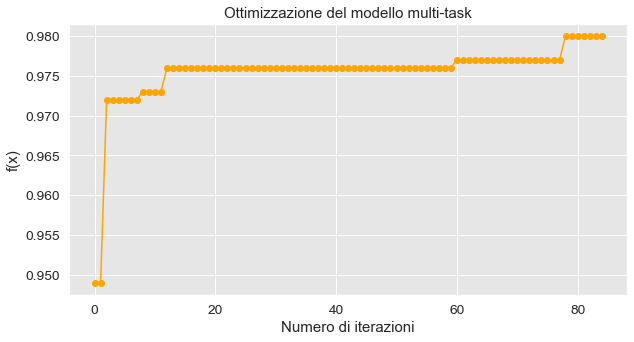

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook", font_scale=1.25)
plt.figure(figsize = (10,5))
plt.plot(list(values), marker = "o", color = "orange")
plt.xlabel("Numero di iterazioni")
plt.title("Ottimizzazione del modello multi-task" )
plt.ylabel("f(x)")
plt.savefig('Report/ottimizzazione_classificazione.png')

In [ ]:
# This is a SigOpt-tuned model
classifier = create_model(assignments)

In [25]:
#model.save_weights('weights/classificazione_multiclasse.hdf5')

In [26]:
predictions = model.predict(X_test)

In [28]:
preds = np.argmax(predictions[0], axis = 1)
print(classification_report(np.argmax(y_test[:,0:43], axis = 1), preds))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96        60
           1       0.96      0.99      0.97       720
           2       0.96      0.98      0.97       750
           3       0.99      0.95      0.97       450
           4       0.99      0.98      0.99       660
           5       0.95      0.99      0.97       630
           6       0.98      0.93      0.96       150
           7       1.00      0.92      0.96       450
           8       0.95      0.99      0.97       450
           9       0.95      0.97      0.96       480
          10       1.00      1.00      1.00       660
          11       0.86      1.00      0.92       420
          12       1.00      0.94      0.97       690
          13       0.94      0.99      0.97       720
          14       1.00      0.98      0.99       270
          15       1.00      0.96      0.98       210
          16       1.00      1.00      1.00       150
          17       1.00    